In [1]:
#Not all these packages are required but they are here for completeness
import importlib
import io
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw, ImageStat
import seaborn as sns
import SimpleITK as sitk
from skimage import io
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes
import staintools
from staintools import stain_normalizer, LuminosityStandardizer, ReinhardColorNormalizer
import sys

Image.MAX_IMAGE_PIXELS = None

In [2]:
print(sys.executable) 

BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

sys.path.append(str(HEMNET_DIR))

from slide import *
from utils import *

/gpfs1/scratch/90days/s4436005/envs/bin/python


In [3]:
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides')
HE_JPEGS_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/jpegs/HandE_2x')
HE_NORM_JPEGS_PATH = Path('/gpfs1/scratch/90days/s4436005/Slides/normalised/vahadane_2x')
TEMPLATE_SLIDE_PATH = SLIDES_PATH.joinpath('2171_T_11524A_2_HandE.svs')

MAG = 2

In [4]:
train_slide_prefixes = ['1820_', '2065_', '2112_', '2148_', '2171_']

In [5]:
he_img_names = []
for img in HE_JPEGS_PATH.glob('*.jpeg'):
    name = img.name
    he_img_names.append(name)
he_img_names.sort()
he_img_names

['1792_T_9500_3_HandE_2x.jpeg',
 '1794_T_9504_3_HandE_2x.jpeg',
 '1798_T_9514_3_HandE_2x.jpeg',
 '1820_N_10545A_2_HandE_2x.jpeg',
 '1820_T_105452F_2_HandE_2x.jpeg',
 '1843_T_9561_3_HandE_2x.jpeg',
 '1879_T_9580_3_HandE_2x.jpeg',
 '1910_T_9637_3_HandE_2x.jpeg',
 '1915_T_10464_3_HandE_2x.jpeg',
 '1919_T_10779_3_HandE_2x.jpeg',
 '1928_T_9644_3_HandE_2x.jpeg',
 '1932_T_9876_3_HandE_2x.jpeg',
 '1939_T_9661_3_HandE_2x.jpeg',
 '1957_T_9668_3_HandE_2x.jpeg',
 '2011_T_9699_3_HandE_2x.jpeg',
 '2019_T_9717_3_HandE_2x.jpeg',
 '2023_T_9727_3_HandE_2x.jpeg',
 '2036_T_9729_3_HandE_2x.jpeg',
 '2038_T_11986_3_HandE_2x.jpeg',
 '2065_N_12752A_2_HandE_2x.jpeg',
 '2065_T_12756A_2_HandE_2x.jpeg',
 '2075_T_9787_3_HandE_2x.jpeg',
 '2090_T_10594_3_HandE_2x.jpeg',
 '2107_T_9806_3_HandE_2x.jpeg',
 '2112_N_12341B_2_HandE_2x.jpeg',
 '2112_T_12335F_2_HandE_2x.jpeg',
 '2148_N_11397A_2_HandE_2x.jpeg',
 '2148_T_11393A_2_HandE_2x.jpeg',
 '2171_N_11521A_2_HandE_2x.jpeg',
 '2171_T_11524A_2_HandE_2x.jpeg',
 '232_T_13230_3

In [6]:
he_norm_img_names = []
for img in HE_NORM_JPEGS_PATH.glob('*.jpeg'):
    name = img.name
    he_norm_img_names.append(name)
he_norm_img_names.sort()
he_norm_img_names

['1792_T_9500_3_HandE_2x.jpeg',
 '1794_T_9504_3_HandE_2x.jpeg',
 '1798_T_9514_3_HandE_2x.jpeg',
 '1820_N_10545A_2_HandE_2x.jpeg',
 '1820_T_105452F_2_HandE_2x.jpeg',
 '1843_T_9561_3_HandE_2x.jpeg',
 '1879_T_9580_3_HandE_2x.jpeg',
 '1910_T_9637_3_HandE_2x.jpeg',
 '1915_T_10464_3_HandE_2x.jpeg',
 '1919_T_10779_3_HandE_2x.jpeg',
 '1928_T_9644_3_HandE_2x.jpeg',
 '1932_T_9876_3_HandE_2x.jpeg',
 '1939_T_9661_3_HandE_2x.jpeg',
 '1957_T_9668_3_HandE_2x.jpeg',
 '2011_T_9699_3_HandE_2x.jpeg',
 '2019_T_9717_3_HandE_2x.jpeg',
 '2023_T_9727_3_HandE_2x.jpeg',
 '2036_T_9729_3_HandE_2x.jpeg',
 '2038_T_11986_3_HandE_2x.jpeg',
 '2065_N_12752A_2_HandE_2x.jpeg',
 '2065_T_12756A_2_HandE_2x.jpeg',
 '2075_T_9787_3_HandE_2x.jpeg',
 '2090_T_10594_3_HandE_2x.jpeg',
 '2107_T_9806_3_HandE_2x.jpeg',
 '2112_N_12341B_2_HandE_2x.jpeg',
 '2112_T_12335F_2_HandE_2x.jpeg',
 '2148_N_11397A_2_HandE_2x.jpeg',
 '2148_T_11393A_2_HandE_2x.jpeg',
 '2171_N_11521A_2_HandE_2x.jpeg',
 '2171_T_11524A_2_HandE_2x.jpeg',
 '232_T_13230_3

In [7]:
imgs_df = pd.DataFrame(list(zip(he_img_names, he_norm_img_names)), columns = ['original','norm'])
imgs_df

,original,norm
0,1792_T_9500_3_HandE_2x.jpeg,1792_T_9500_3_HandE_2x.jpeg
1,1794_T_9504_3_HandE_2x.jpeg,1794_T_9504_3_HandE_2x.jpeg
2,1798_T_9514_3_HandE_2x.jpeg,1798_T_9514_3_HandE_2x.jpeg
3,1820_N_10545A_2_HandE_2x.jpeg,1820_N_10545A_2_HandE_2x.jpeg
4,1820_T_105452F_2_HandE_2x.jpeg,1820_T_105452F_2_HandE_2x.jpeg
5,1843_T_9561_3_HandE_2x.jpeg,1843_T_9561_3_HandE_2x.jpeg
6,1879_T_9580_3_HandE_2x.jpeg,1879_T_9580_3_HandE_2x.jpeg
7,1910_T_9637_3_HandE_2x.jpeg,1910_T_9637_3_HandE_2x.jpeg
8,1915_T_10464_3_HandE_2x.jpeg,1915_T_10464_3_HandE_2x.jpeg
9,1919_T_10779_3_HandE_2x.jpeg,1919_T_10779_3_HandE_2x.jpeg


In [8]:
is_train_slide = lambda x: any([prefix in x for prefix in train_slide_prefixes])

In [9]:
imgs_train_df = imgs_df[imgs_df.original.apply(is_train_slide)]
imgs_train_df

,original,norm
3,1820_N_10545A_2_HandE_2x.jpeg,1820_N_10545A_2_HandE_2x.jpeg
4,1820_T_105452F_2_HandE_2x.jpeg,1820_T_105452F_2_HandE_2x.jpeg
19,2065_N_12752A_2_HandE_2x.jpeg,2065_N_12752A_2_HandE_2x.jpeg
20,2065_T_12756A_2_HandE_2x.jpeg,2065_T_12756A_2_HandE_2x.jpeg
24,2112_N_12341B_2_HandE_2x.jpeg,2112_N_12341B_2_HandE_2x.jpeg
25,2112_T_12335F_2_HandE_2x.jpeg,2112_T_12335F_2_HandE_2x.jpeg
26,2148_N_11397A_2_HandE_2x.jpeg,2148_N_11397A_2_HandE_2x.jpeg
27,2148_T_11393A_2_HandE_2x.jpeg,2148_T_11393A_2_HandE_2x.jpeg
28,2171_N_11521A_2_HandE_2x.jpeg,2171_N_11521A_2_HandE_2x.jpeg
29,2171_T_11524A_2_HandE_2x.jpeg,2171_T_11524A_2_HandE_2x.jpeg


In [10]:
def plot_histogram(img, axes):
    axes.hist(img.ravel(), bins = 256, color = 'orange', alpha = 0.5)
    axes.hist(img[:, :, 0].ravel(), bins = 256, color = 'red', alpha = 0.5)
    axes.hist(img[:, :, 1].ravel(), bins = 256, color = 'green', alpha = 0.5)
    axes.hist(img[:, :, 2].ravel(), bins = 256, color = 'blue', alpha = 0.5)
    axes.axvline(img.ravel().mean(), color = 'orange')
    axes.axvline(img[:, :, 0].ravel().mean(), color = 'red')
    axes.axvline(img[:, :, 1].ravel().mean(), color = 'green')
    axes.axvline(img[:, :, 2].ravel().mean(), color = 'blue')
    axes.set_xlabel('Intensity Value')
    axes.set_ylabel('Pixel Count')
    axes.legend(['Total_Mean','Red_Mean', 'Green_Mean', 'Blue_Mean', 'Total','Red_Channel', 'Green_Channel', 'Blue_Channel'])
    axes.set_xlim([0, 255])

In [11]:
NUM = 9
img_norm_name = imgs_train_df.norm.iloc[NUM]
img_name = imgs_train_df.original.iloc[NUM]
img_norm = io.imread(HE_NORM_JPEGS_PATH.joinpath(img_norm_name))
img = io.imread(HE_JPEGS_PATH.joinpath(img_name))

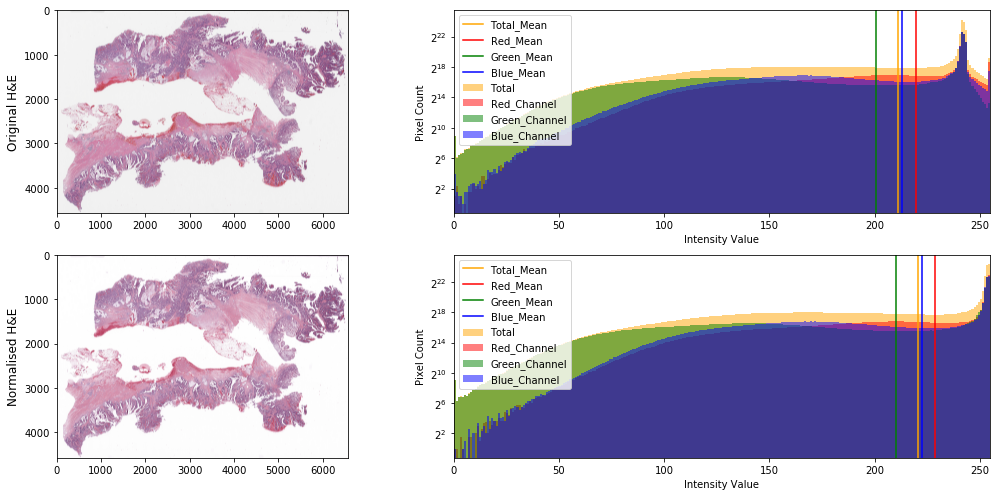

In [12]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (15,7))
axs[0,0].imshow(img, interpolation = 'bicubic')
plot_histogram(img, axs[0,1])
axs[0,1].set_yscale('log', basey = 2)
axs[1,0].imshow(img_norm, interpolation = 'bicubic')
plot_histogram(img_norm, axs[1,1])
axs[1,1].set_yscale('log', basey = 2)
#axs[0,1].set_ylim([0, 500000])
#axs[1,1].set_ylim([0, 500000])
axs[0,0].set_ylabel('Original H&E', size = 'large')
axs[1,0].set_ylabel('Normalised H&E', size = 'large')
fig.tight_layout()
plt.show()

### Plot Channel Means

In [103]:
og_means_df = imgs_train_df[['original']].copy()
og_means_df = og_means_df.rename(columns={'original':'img_name'})
og_means_df = og_means_df.reindex(og_means_df.columns.tolist() + ['red', 'green', 'blue', 'total'], axis = 1)

In [104]:
og_means_df

,img_name,red,green,blue,total
3,1820_N_10545A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
4,1820_T_105452F_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
19,2065_N_12752A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
20,2065_T_12756A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
24,2112_N_12341B_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
25,2112_T_12335F_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
26,2148_N_11397A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
27,2148_T_11393A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
28,2171_N_11521A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN
29,2171_T_11524A_2_HandE_2x.jpeg,NaN,NaN,NaN,NaN


In [107]:
def df_img_means(row, img_path):
    img_name = row['img_name']
    img = io.imread(img_path.joinpath(img_name))
    row['total'] = img.ravel().mean()
    row['red'] = img[:, :, 0].ravel().mean()
    row['green'] = img[:, :, 1].ravel().mean()
    row['blue'] = img[:, :, 2].ravel().mean()
    return row

In [109]:
og_means_df.apply(df_img_means, axis = 1, args = (HE_JPEGS_PATH,))

,img_name,red,green,blue,total
3,1820_N_10545A_2_HandE_2x.jpeg,220.866625,195.749549,209.567069,208.727748
4,1820_T_105452F_2_HandE_2x.jpeg,225.660951,211.060021,220.695259,219.138744
19,2065_N_12752A_2_HandE_2x.jpeg,228.432200,216.474037,223.793813,222.900017
20,2065_T_12756A_2_HandE_2x.jpeg,212.178643,193.073662,208.405717,204.552674
24,2112_N_12341B_2_HandE_2x.jpeg,220.841308,213.516232,222.243301,218.866947
25,2112_T_12335F_2_HandE_2x.jpeg,219.990494,202.688770,214.979690,212.552985
26,2148_N_11397A_2_HandE_2x.jpeg,222.783262,199.137030,211.263468,211.061253
27,2148_T_11393A_2_HandE_2x.jpeg,211.613635,190.364098,206.863365,202.947032
28,2171_N_11521A_2_HandE_2x.jpeg,226.947972,211.049231,219.776790,219.257997
29,2171_T_11524A_2_HandE_2x.jpeg,219.533083,200.499551,213.024462,211.019032


In [64]:
def img_means(img):
    means = {}
    means['total'] = img.ravel().mean()
    means['red'] = img[:, :, 0].ravel().mean()
    means['green'] = img[:, :, 1].ravel().mean()
    means['blue'] = img[:, :, 2].ravel().mean()
    means_series = pd.Series(means)
    means_series.reindex(index = [2])
    return means_series

In [62]:
og_means_df = pd.DataFrame()

In [63]:
#pd.concat([og_means_df, pd.Series(img_means(img)), pd.Series(img_means(img))], axis = 1, sort = True)
pd.concat([og_means_df, img_means(img), img_means(img)], axis = 1, sort = True)

,0,1
blue,213.024462,213.024462
green,200.499551,200.499551
red,219.533083,219.533083
total,211.019032,211.019032


In [35]:
NUM = 0
img_norm_name = imgs_train_df.norm.iloc[NUM]
img_name = imgs_train_df.original.iloc[NUM]
img_norm = io.imread(HE_NORM_JPEGS_PATH.joinpath(img_norm_name))
img = io.imread(HE_JPEGS_PATH.joinpath(img_name))

In [36]:
og_means_df = pd.DataFrame()
norm_means_df = pd.DataFrame()
for img_name in imgs_train_df.original:
    img = io.imread(HE_JPEGS_PATH.joinpath(img_name))
    img_norm = io.imread(HE_NORM_JPEGS_PATH.joinpath(img_name))
    og_means_df = pd.concat([og_means_df, pd.Series(img_means(img))], axis = 1, sort = True)
    norm_means_df = pd.concat([norm_means_df, pd.Series(img_means(img_norm))], axis = 1, sort = True)

In [37]:
og_means_df.T

,blue,green,red,total
0,209.567069,195.749549,220.866625,208.727748
0,220.695259,211.060021,225.660951,219.138744
0,223.793813,216.474037,228.432200,222.900017
0,208.405717,193.073662,212.178643,204.552674
0,222.243301,213.516232,220.841308,218.866947
0,214.979690,202.688770,219.990494,212.552985
0,211.263468,199.137030,222.783262,211.061253
0,206.863365,190.364098,211.613635,202.947032
0,219.776790,211.049231,226.947972,219.257997
0,213.024462,200.499551,219.533083,211.019032


In [38]:
norm_means_df.T

,blue,green,red,total
0,217.552036,202.973179,226.276040,215.600418
0,226.213947,215.837483,232.356335,224.802589
0,231.325511,223.245890,237.639539,230.736980
0,214.702856,200.194208,223.614554,212.837206
0,225.566813,215.102102,230.526899,223.731938
0,219.992892,207.538357,228.341158,218.624136
0,219.981300,208.362790,231.062389,219.802160
0,213.643299,198.168059,221.816730,211.209363
0,227.802105,218.476636,235.202751,227.160497
0,222.462796,210.173433,228.924955,220.520395


['#4c72b0',
 '#dd8452',
 '#55a868',
 '#c44e52',
 '#8172b3',
 '#937860',
 '#da8bc3',
 '#8c8c8c',
 '#ccb974',
 '#64b5cd']

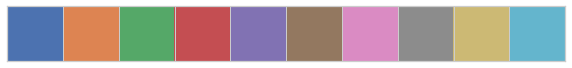

In [39]:
current_palette = sns.color_palette()
sns.palplot(current_palette)
current_palette.as_hex()

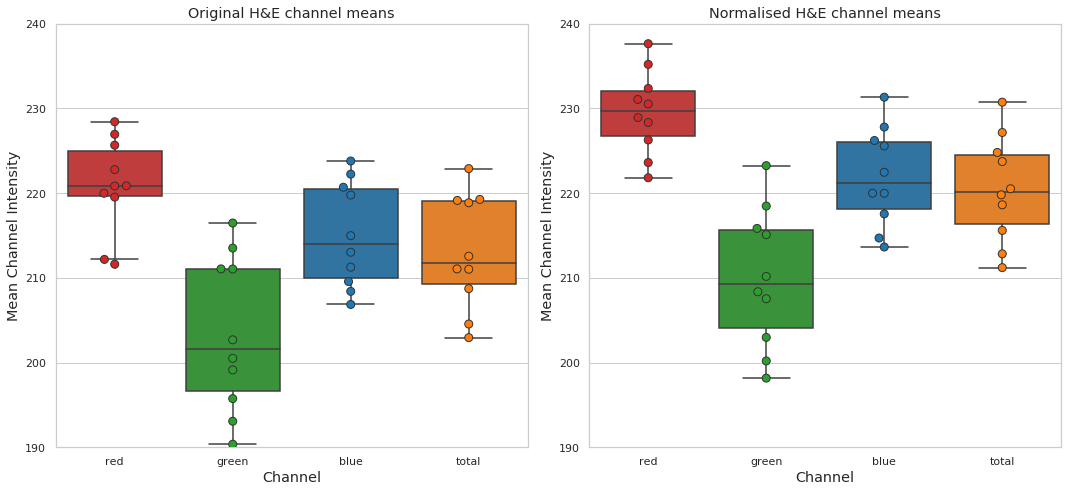

In [40]:
fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = (15, 7))
palette = {'red': '#d62728', 'green': '#2ca02c', 'blue': '#1f77b4', 'total': '#ff7f0e'}

sns.set_style("whitegrid")
#Settings to apply to all axis
for ax in axs:
    ax.set_ylim([190, 240])
    ax.set_ylabel('Mean Channel Intensity', size = 'large')
    ax.set_xlabel('Channel', size = 'large')
    
sns.boxplot(data = og_means_df.T, order = ['red', 'green', 'blue', 'total'], palette = palette, ax = axs[0], )
sns.swarmplot(data = og_means_df.T, order = ['red', 'green', 'blue', 'total'], palette = palette, ax = axs[0],
              size = 8, edgecolor = "0.2", linewidth=1)
sns.boxplot(data = norm_means_df.T, order = ['red', 'green', 'blue', 'total'], palette = palette, ax = axs[1])
sns.swarmplot(data = norm_means_df.T, order = ['red', 'green', 'blue', 'total'], palette = palette, ax = axs[1],
              size = 8, edgecolor = "0.2", linewidth=1)

axs[0].set_title('Original H&E channel means', size = 'large')
axs[1].set_title('Normalised H&E channel means', size = 'large')


    
fig.tight_layout()

### Remove Background